In [52]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.distance import distance


#for data visualization
df_sample_trail_gnss = pd.read_csv("./kaggle/input/smartphone-decimeter-2023/sdc2023/train/2020-06-25-00-34-us-ca-mtv-sb-101/pixel4/device_gnss.csv")
df_sample_trail_gt = pd.read_csv("./kaggle/input/smartphone-decimeter-2023/sdc2023/train/2020-06-25-00-34-us-ca-mtv-sb-101/pixel4/ground_truth.csv")
df_sample_trail_imu = pd.read_csv("./kaggle/input/smartphone-decimeter-2023/sdc2023/train/2020-06-25-00-34-us-ca-mtv-sb-101/pixel4/device_imu.csv")

In [53]:
df_sample_trail_gnss.isnull().sum()

MessageType                                      0
utcTimeMillis                                    0
TimeNanos                                        0
LeapSecond                                       0
TimeUncertaintyNanos                         46628
FullBiasNanos                                    0
BiasNanos                                        0
BiasUncertaintyNanos                             0
DriftNanosPerSecond                              0
DriftUncertaintyNanosPerSecond                   0
HardwareClockDiscontinuityCount                  0
Svid                                             0
TimeOffsetNanos                                  0
State                                            0
ReceivedSvTimeNanos                              0
ReceivedSvTimeUncertaintyNanos                   0
Cn0DbHz                                          0
PseudorangeRateMetersPerSecond                   0
PseudorangeRateUncertaintyMetersPerSecond        0
AccumulatedDeltaRangeState     

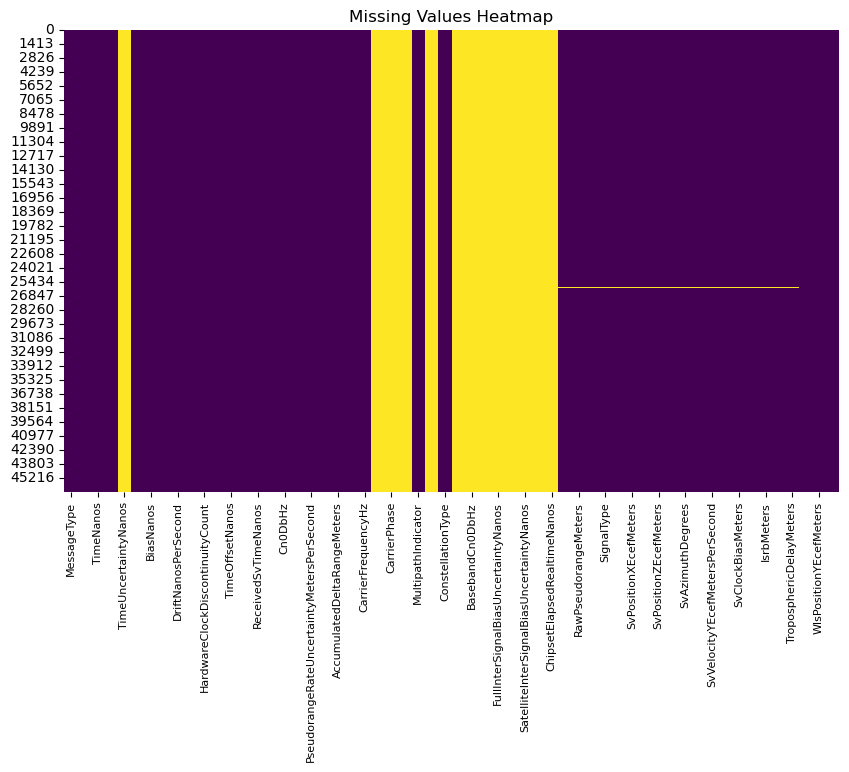

In [54]:
# Create a heatmap of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df_sample_trail_gnss.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xticks(fontsize=8)
plt.show()

In [55]:
df_sample_trail_gt.isnull().sum()

MessageType                  0
Provider                     0
LatitudeDegrees              0
LongitudeDegrees             0
AltitudeMeters               0
SpeedMps                     0
AccuracyMeters               0
BearingDegrees               0
UnixTimeMillis               0
SpeedAccuracyMps          1299
BearingAccuracyDegrees    1299
elapsedRealtimeNanos      1299
VerticalAccuracyMeters    1299
dtype: int64

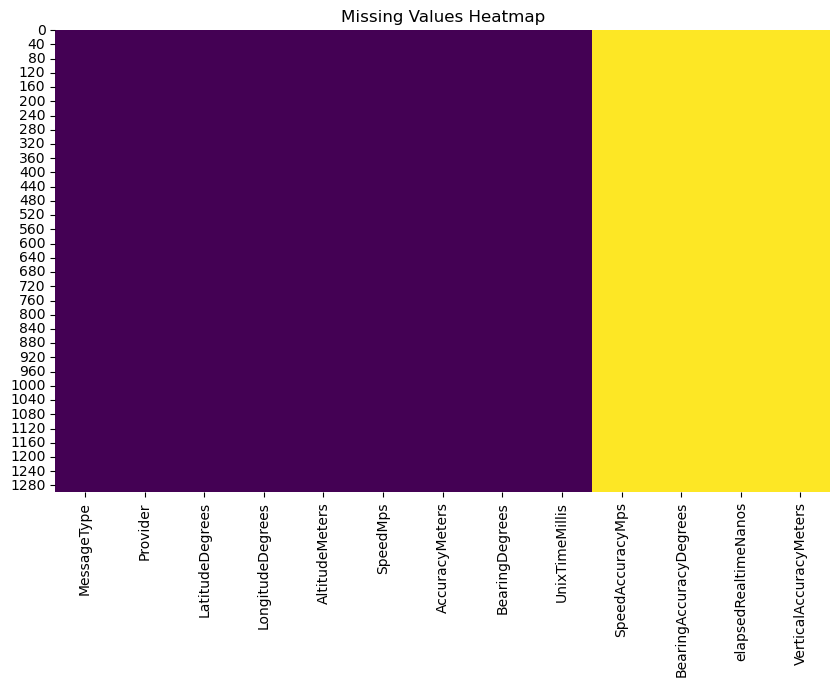

In [56]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_sample_trail_gt.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [57]:
df_sample_trail_imu.isnull().sum()

MessageType                  0
utcTimeMillis                0
elapsedRealtimeNanos    205070
MeasurementX                 0
MeasurementY                 0
MeasurementZ                 0
BiasX                        0
BiasY                        0
BiasZ                        0
dtype: int64

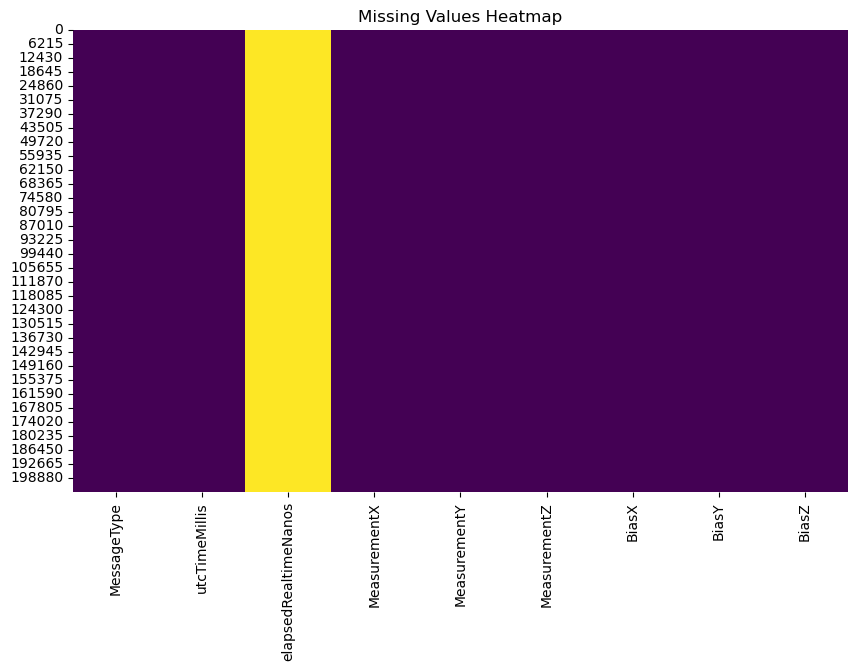

In [58]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_sample_trail_imu.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [59]:
columns_to_drop_gnss = ['TimeUncertaintyNanos', 'ChipsetElapsedRealtimeNanos', 'CarrierCycles', 'CarrierPhase',
                   'CarrierPhaseUncertainty', 'SnrInDb', 'AgcDb', 'BasebandCn0DbHz', 'FullInterSignalBiasNanos',
                   'FullInterSignalBiasUncertaintyNanos', 'SatelliteInterSignalBiasNanos',
                   'SatelliteInterSignalBiasUncertaintyNanos', 'CodeType', 'ArrivalTimeNanosSinceGpsEpoch']

columns_to_impute_numeric_gnss = ['RawPseudorangeMeters', 'RawPseudorangeUncertaintyMeters',
                             'ReceivedSvTimeNanosSinceGpsEpoch', 'SvPositionXEcefMeters',
                             'SvPositionYEcefMeters', 'SvPositionZEcefMeters', 'SvElevationDegrees',
                             'SvAzimuthDegrees', 'SvVelocityXEcefMetersPerSecond',
                             'SvVelocityYEcefMetersPerSecond', 'SvVelocityZEcefMetersPerSecond',
                             'SvClockBiasMeters', 'SvClockDriftMetersPerSecond', 'IsrbMeters',
                             'IonosphericDelayMeters', 'TroposphericDelayMeters']

columns_to_impute_non_numeric_gnss = ['SignalType']
df_cleaned_gnss = df_sample_trail_gnss.drop(columns=columns_to_drop_gnss)
imputer_numeric_mean = SimpleImputer(strategy='mean')
df_cleaned_gnss[columns_to_impute_numeric_gnss] = imputer_numeric_mean.fit_transform(df_cleaned_gnss[columns_to_impute_numeric_gnss])
imputer_non_numeric_freq = SimpleImputer(strategy='most_frequent')
df_cleaned_gnss[columns_to_impute_non_numeric_gnss] = imputer_non_numeric_freq.fit_transform(df_cleaned_gnss[columns_to_impute_non_numeric_gnss])

columns_to_drop_gt = ['SpeedAccuracyMps', 'BearingAccuracyDegrees', 'elapsedRealtimeNanos', 'VerticalAccuracyMeters']
df_cleaned_gt = df_sample_trail_gt.drop(columns=columns_to_drop_gt)

df_cleaned_imu = df_sample_trail_imu.drop(columns='elapsedRealtimeNanos')

In [60]:
df_cleaned_gnss.head()

,MessageType,utcTimeMillis,TimeNanos,LeapSecond,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,...,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond,IsrbMeters,IonosphericDelayMeters,TroposphericDelayMeters,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
0,Raw,1593045252440,1047929361000000,18,-1276032541079953176,0.038029,19.234471,-23.264117,11.553386,403,...,45.249743,2921.007727,-114240.991171,-0.002747,0.0,2.990605,3.330763,-2.692783e+06,-4.297236e+06,3.855231e+06
1,Raw,1593045252440,1047929361000000,18,-1276032541079953176,0.038029,19.234471,-23.264117,11.553386,403,...,2683.408375,727.894656,6344.271476,0.000551,0.0,4.233219,9.598289,-2.692783e+06,-4.297236e+06,3.855231e+06
2,Raw,1593045252440,1047929361000000,18,-1276032541079953176,0.038029,19.234471,-23.264117,11.553386,403,...,2112.281409,1639.029553,-66543.908717,-0.000458,0.0,3.189919,4.111997,-2.692783e+06,-4.297236e+06,3.855231e+06
3,Raw,1593045252440,1047929361000000,18,-1276032541079953176,0.038029,19.234471,-23.264117,11.553386,403,...,-728.664279,-2495.388750,-52349.705491,-0.001107,0.0,4.307212,5.539522,-2.692783e+06,-4.297236e+06,3.855231e+06
4,Raw,1593045252440,1047929361000000,18,-1276032541079953176,0.038029,19.234471,-23.264117,11.553386,403,...,-1692.724424,-1274.485806,68762.686062,0.003014,0.0,2.381497,2.830938,-2.692783e+06,-4.297236e+06,3.855231e+06


In [61]:
df_cleaned_gt.head()

,MessageType,Provider,LatitudeDegrees,LongitudeDegrees,AltitudeMeters,SpeedMps,AccuracyMeters,BearingDegrees,UnixTimeMillis
0,Fix,GT,37.428290,-122.072528,-28.208800,0.013612,0.1,238.64088,1593045253440
1,Fix,GT,37.428290,-122.072528,-28.209801,0.020512,0.1,238.64206,1593045254440
2,Fix,GT,37.428289,-122.072529,-28.221802,0.473221,0.1,238.31201,1593045255440
3,Fix,GT,37.428283,-122.072537,-28.208162,1.551287,0.1,233.01088,1593045256440
4,Fix,GT,37.428272,-122.072555,-28.189849,2.316935,0.1,233.92097,1593045257440


In [62]:
df_cleaned_imu.head()

,MessageType,utcTimeMillis,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ
0,UncalAccel,1593045252698,0.279960,9.570692,-0.328415,0.00000,0.00000,0.000000
1,UncalMag,1593045252701,72.112495,-67.275000,2.400000,33.96469,-31.34996,2.673736
2,UncalAccel,1593045252707,0.174676,9.528818,0.307478,0.00000,0.00000,0.000000
3,UncalMag,1593045252711,72.299995,-66.637500,1.837500,33.96469,-31.34996,2.673736
4,UncalAccel,1593045252717,-0.510868,9.380463,0.298505,0.00000,0.00000,0.000000


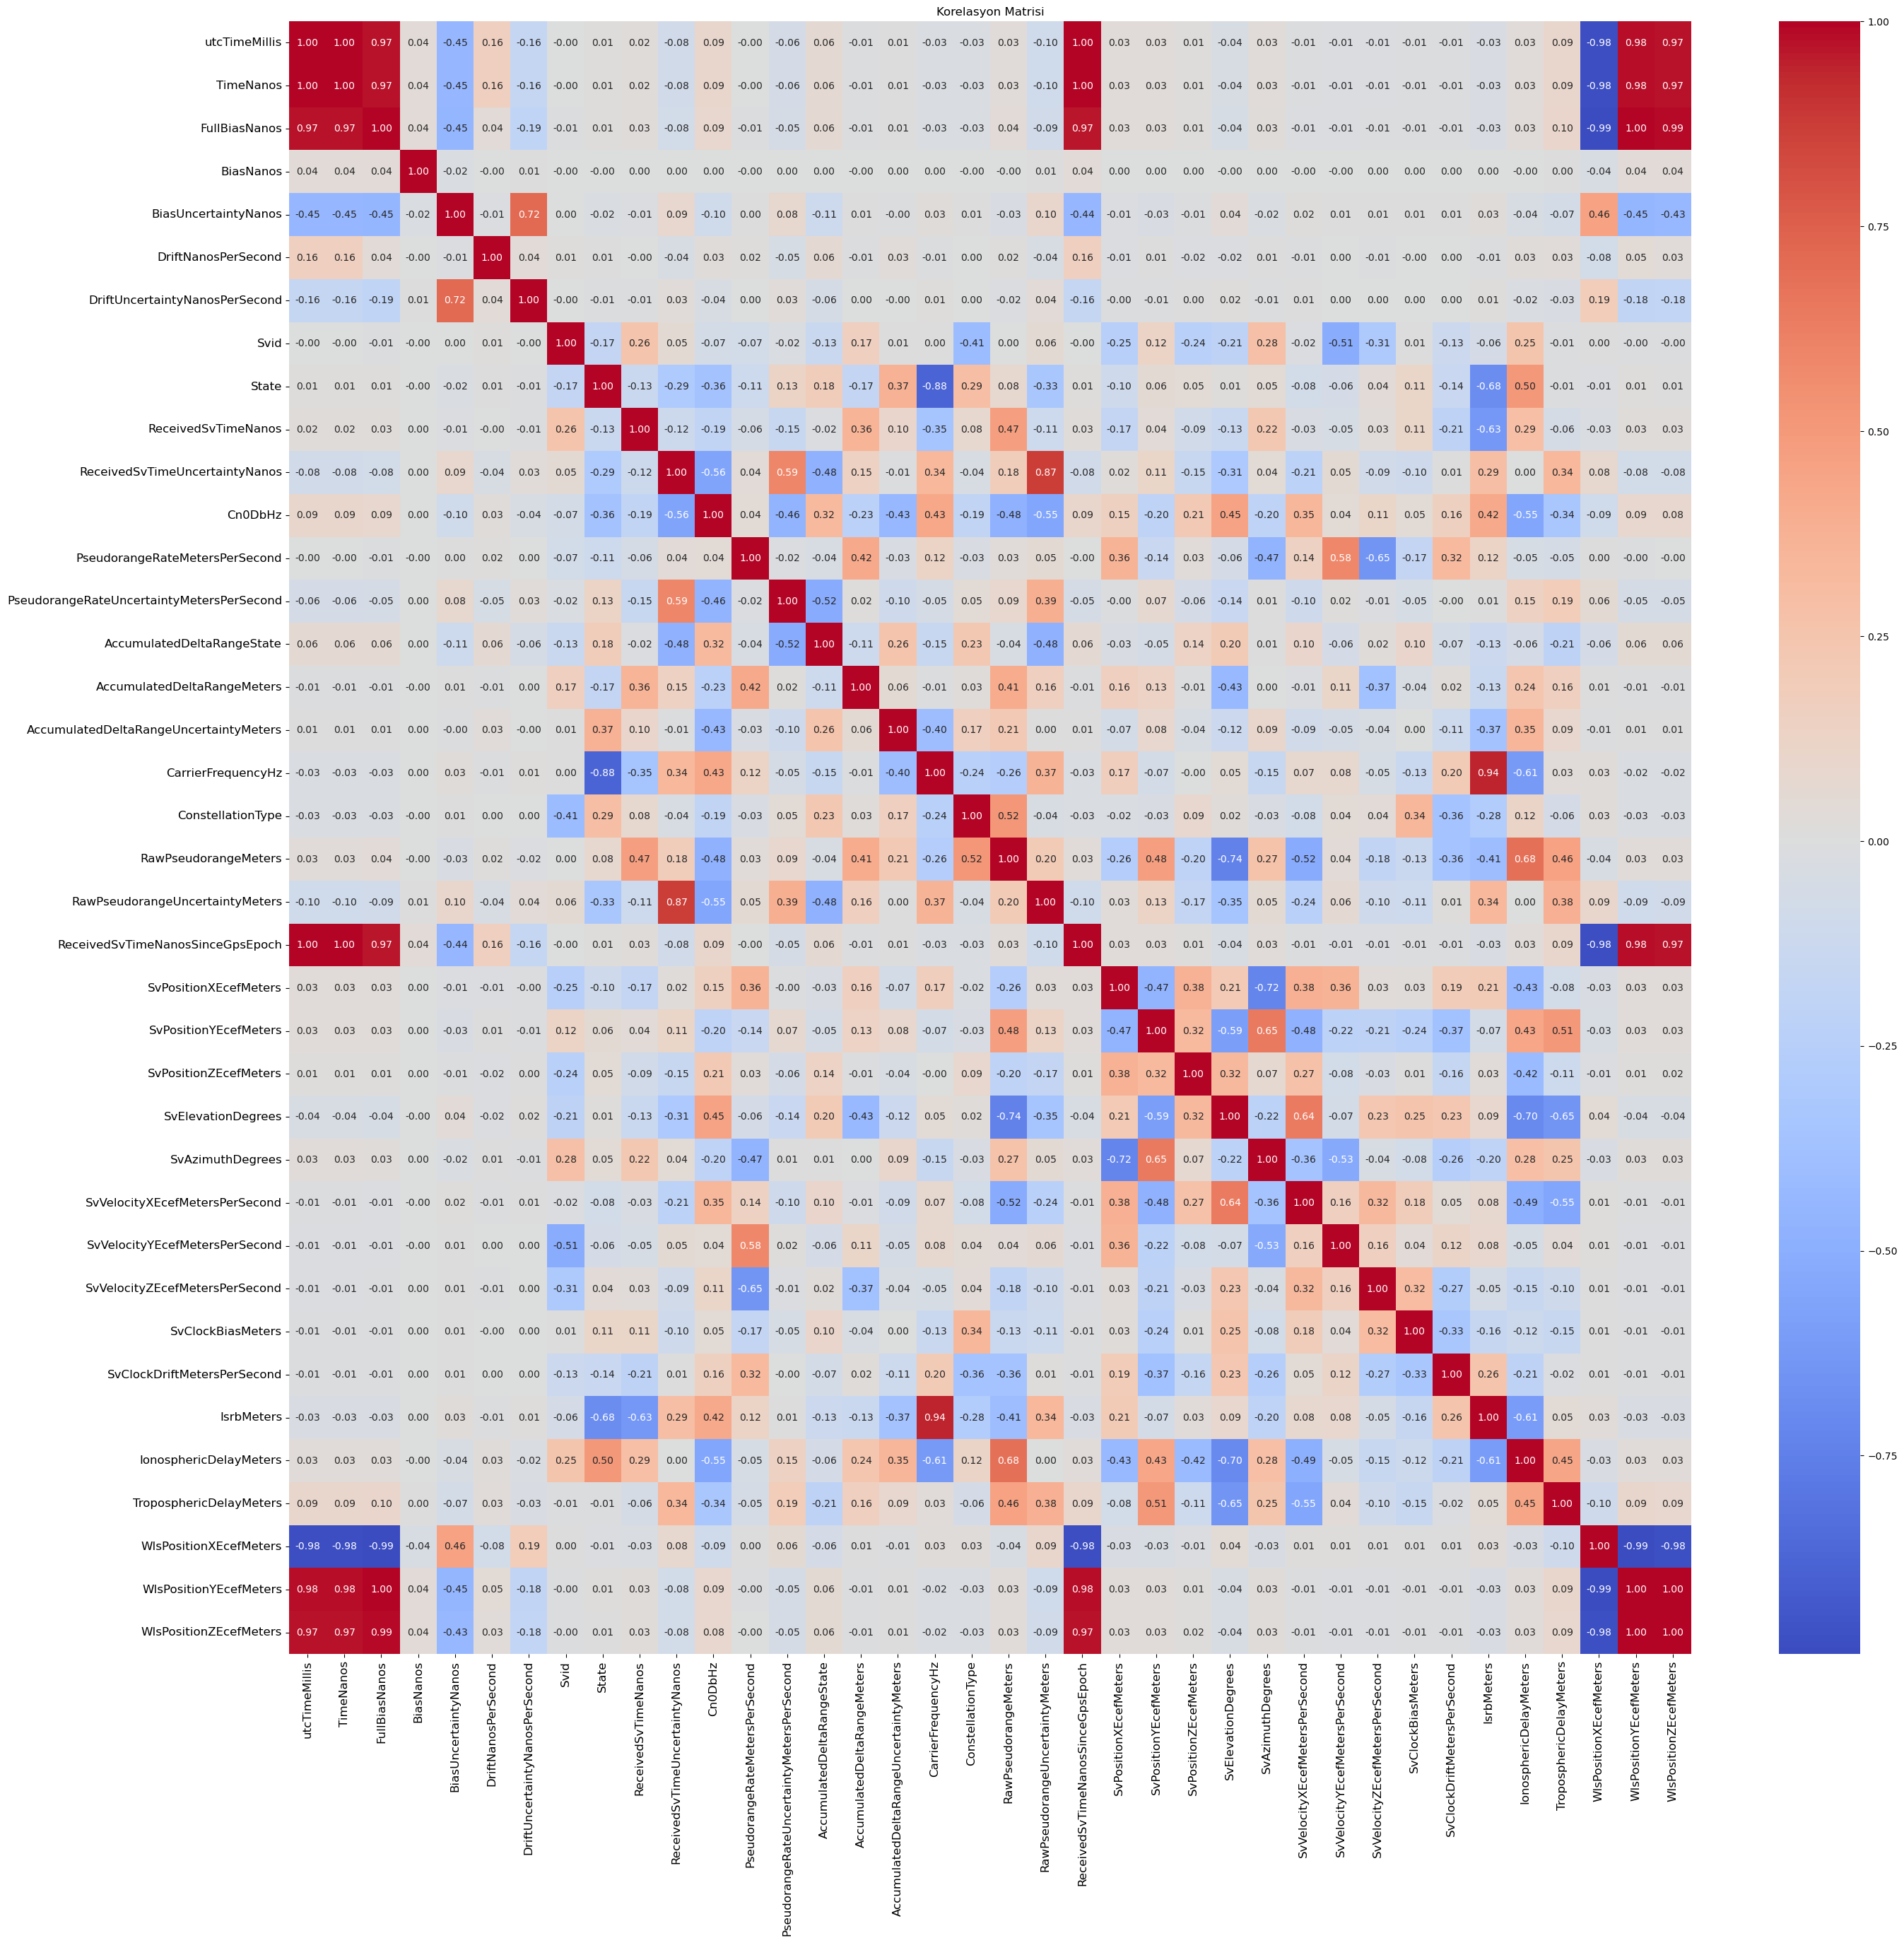

In [63]:
df_sample_trail_gnss_numeric = df_cleaned_gnss.select_dtypes(include=[np.number])
columns_to_drop_2 = ['LeapSecond', 'HardwareClockDiscontinuityCount', 'TimeOffsetNanos', 'MultipathIndicator']
df_sample_trail_gnss_numeric = df_sample_trail_gnss_numeric.drop(columns=columns_to_drop_2)

correlation_matrix = df_sample_trail_gnss_numeric.corr()
plt.figure(figsize=(32, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasyon Matrisi')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [64]:
#choosing the features due to correlation matrix
df_gnss_corr = df_sample_trail_gnss[["utcTimeMillis","TimeNanos","FullBiasNanos","ReceivedSvTimeNanosSinceGpsEpoch","WlsPositionXEcefMeters", "WlsPositionYEcefMeters", "WlsPositionZEcefMeters"]].copy()
df_gnss_corr.head()

,utcTimeMillis,TimeNanos,FullBiasNanos,ReceivedSvTimeNanosSinceGpsEpoch,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
0,1593045252440,1047929361000000,-1276032541079953176,1.277080e+18,-2.692783e+06,-4.297236e+06,3.855231e+06
1,1593045252440,1047929361000000,-1276032541079953176,1.277080e+18,-2.692783e+06,-4.297236e+06,3.855231e+06
2,1593045252440,1047929361000000,-1276032541079953176,1.277080e+18,-2.692783e+06,-4.297236e+06,3.855231e+06
3,1593045252440,1047929361000000,-1276032541079953176,1.277080e+18,-2.692783e+06,-4.297236e+06,3.855231e+06
4,1593045252440,1047929361000000,-1276032541079953176,1.277080e+18,-2.692783e+06,-4.297236e+06,3.855231e+06


In [65]:
import glob
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import numpy as np

def preprocess_train_data(df_sample_trail_gnss,df_sample_trail_gt, df_sample_trail_imu):
    columns_to_drop_gt = ['MessageType', 'Provider', 'SpeedAccuracyMps', 'BearingAccuracyDegrees',
                          'elapsedRealtimeNanos', 'VerticalAccuracyMeters']
    df_cleaned_gt = df_sample_trail_gt.drop(columns=columns_to_drop_gt)
    df_cleaned_imu = df_sample_trail_imu.drop(columns='elapsedRealtimeNanos')
    df_corr_gnss = df_sample_trail_gnss[
        ["utcTimeMillis", "TimeNanos", "FullBiasNanos", "ReceivedSvTimeNanosSinceGpsEpoch", "WlsPositionXEcefMeters",
         "WlsPositionYEcefMeters", "WlsPositionZEcefMeters"]].copy()

    df_cleaned2_imu = df_cleaned_imu[~df_cleaned_imu['MessageType'].isin(['UncalMag', 'UncalGyro'])]

    df_sade_gnss = df_corr_gnss.groupby("utcTimeMillis").agg({
        "TimeNanos": "mean",
        "FullBiasNanos": "mean",
        "ReceivedSvTimeNanosSinceGpsEpoch": "mean",
        "WlsPositionXEcefMeters": "mean",
        "WlsPositionYEcefMeters": "mean",
        "WlsPositionZEcefMeters": "mean"
    }).reset_index()
    
    df_gnss_gt = pd.merge(df_sade_gnss, df_cleaned_gt, how='outer', left_on=['utcTimeMillis'], right_on=['UnixTimeMillis'])
    df_gnss_gt['LatitudeDegrees'] = df_gnss_gt['LatitudeDegrees'].interpolate()
    df_gnss_gt['LongitudeDegrees'] = df_gnss_gt['LongitudeDegrees'].interpolate()
    df_gnss_gt['AltitudeMeters'] = df_gnss_gt['AltitudeMeters'].interpolate()
    df_gnss_gt['SpeedMps'] = df_gnss_gt['SpeedMps'].interpolate()
    df_gnss_gt['AccuracyMeters'] = df_gnss_gt['AccuracyMeters'].interpolate()
    df_gnss_gt['BearingDegrees'] = df_gnss_gt['BearingDegrees'].interpolate()
    df_gnss_gt = df_gnss_gt.drop(columns=['UnixTimeMillis'])
    
    # Merging GNSS-Ground Truth Data with IMU Data
    df_gnss_gt_imu = pd.merge_asof(df_gnss_gt, df_cleaned2_imu, on='utcTimeMillis', direction='nearest')
    df_gnss_gt_imu['MeasurementX'] = df_gnss_gt_imu['MeasurementX'].interpolate()
    df_gnss_gt_imu['MeasurementY'] = df_gnss_gt_imu['MeasurementY'].interpolate()
    df_gnss_gt_imu['MeasurementZ'] = df_gnss_gt_imu['MeasurementZ'].interpolate()
    df_gnss_gt_imu['BiasX'] = df_gnss_gt_imu['BiasX'].interpolate()
    df_gnss_gt_imu['BiasY'] = df_gnss_gt_imu['BiasY'].interpolate()
    df_gnss_gt_imu['BiasZ'] = df_gnss_gt_imu['BiasZ'].interpolate()
    df_gnss_gt_imu = df_gnss_gt_imu[df_gnss_gt_imu['WlsPositionXEcefMeters'].notna()]
    df_gnss_gt_imu = df_gnss_gt_imu[df_gnss_gt_imu['LatitudeDegrees'].notna()]

    df_gnss_gt_imu = df_gnss_gt_imu.drop(columns=['MessageType'])

    return df_gnss_gt_imu

train_dfs = []

for dirname in tqdm(sorted(glob.glob('C:/Users/elmas/Desktop/aiproje/kaggle/input/smartphone-decimeter-2023/sdc2023/train/*/*'))):
    gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
    imu_df = pd.read_csv(f'{dirname}/device_imu.csv')
    gt_df = pd.read_csv(f'{dirname}/ground_truth.csv')
    df_gnss_gt_imu = preprocess_train_data(gnss_df, gt_df, imu_df)

    train_dfs.append(df_gnss_gt_imu)
    
train_df1 = pd.concat(train_dfs)
train_df1.to_csv('train_merged.csv', index=False)


  8%|▊         | 13/156 [00:06<01:05,  2.19it/s]C:\Users\elmas\AppData\Local\Temp\ipykernel_13552\3830621425.py:54: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
  9%|▉         | 14/156 [00:06<01:06,  2.15it/s]C:\Users\elmas\AppData\Local\Temp\ipykernel_13552\3830621425.py:54: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
 12%|█▏        | 18/156 [00:08<01:03,  2.17it/s]C:\Users\elmas\AppData\Local\Temp\ipykernel_13552\3830621425.py:54: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
 13%|█▎        | 21/156 [00:10<01:16,  1.76it/s]C:\Users\elmas\AppData\Local\Temp\ipykernel_13552\3830621425.py:54: DtypeWarning: Columns (21) have mixed types. Specify dtype option on im

In [66]:
train_df1.head()

,utcTimeMillis,TimeNanos,FullBiasNanos,ReceivedSvTimeNanosSinceGpsEpoch,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters,LatitudeDegrees,LongitudeDegrees,AltitudeMeters,SpeedMps,AccuracyMeters,BearingDegrees,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ
1,1593045253440,1.047930e+15,-1.276033e+18,1.277080e+18,-2.692781e+06,-4.297233e+06,3.855231e+06,37.428290,-122.072528,-28.208800,0.013612,0.1,238.64088,-1.135992,10.039685,0.343968,0.0,0.0,0.0
2,1593045254440,1.047931e+15,-1.276033e+18,1.277080e+18,-2.692783e+06,-4.297236e+06,3.855231e+06,37.428290,-122.072528,-28.209801,0.020512,0.1,238.64206,-1.045065,9.919446,0.227916,0.0,0.0,0.0
3,1593045255440,1.047932e+15,-1.276033e+18,1.277080e+18,-2.692782e+06,-4.297236e+06,3.855231e+06,37.428289,-122.072529,-28.221802,0.473221,0.1,238.31201,-1.342374,9.657433,-1.261616,0.0,0.0,0.0
4,1593045256440,1.047933e+15,-1.276033e+18,1.277080e+18,-2.692780e+06,-4.297235e+06,3.855229e+06,37.428283,-122.072537,-28.208162,1.551287,0.1,233.01088,-1.033101,9.797412,-0.673580,0.0,0.0,0.0
5,1593045257440,1.047934e+15,-1.276033e+18,1.277080e+18,-2.692782e+06,-4.297234e+06,3.855228e+06,37.428272,-122.072555,-28.189849,2.316935,0.1,233.92097,1.427319,9.753145,-0.129811,0.0,0.0,0.0


In [67]:
def preprocess_test_data(df_sample_trail_gnss,df_sample_trail_imu):
    df_cleaned_imu = df_sample_trail_imu.drop(columns='elapsedRealtimeNanos')
    df_corr_gnss = df_sample_trail_gnss[
        ["utcTimeMillis", "TimeNanos", "FullBiasNanos", "ReceivedSvTimeNanosSinceGpsEpoch", "WlsPositionXEcefMeters",
         "WlsPositionYEcefMeters", "WlsPositionZEcefMeters"]].copy()

    df_cleaned2_imu = df_cleaned_imu[~df_cleaned_imu['MessageType'].isin(['UncalMag', 'UncalGyro'])]
    df_sade_gnss = df_corr_gnss.groupby("utcTimeMillis").agg({
        "TimeNanos": "mean",
        "FullBiasNanos": "mean",
        "ReceivedSvTimeNanosSinceGpsEpoch": "mean",
        "WlsPositionXEcefMeters": "mean",
        "WlsPositionYEcefMeters": "mean",
        "WlsPositionZEcefMeters": "mean"
    }).reset_index()
    
    # Merging GNSS-Ground Truth Data with IMU Data
    df_gnss_imu = pd.merge_asof(df_sade_gnss, df_cleaned2_imu, on='utcTimeMillis', direction='nearest')
    df_gnss_imu['MeasurementX'] = df_gnss_imu['MeasurementX'].interpolate()
    df_gnss_imu['MeasurementY'] = df_gnss_imu['MeasurementY'].interpolate()
    df_gnss_imu['MeasurementZ'] = df_gnss_imu['MeasurementZ'].interpolate()
    df_gnss_imu['BiasX'] = df_gnss_imu['BiasX'].interpolate()
    df_gnss_imu['BiasY'] = df_gnss_imu['BiasY'].interpolate()
    df_gnss_imu['BiasZ'] = df_gnss_imu['BiasZ'].interpolate()
    df_gnss_imu = df_gnss_imu[df_gnss_imu['WlsPositionXEcefMeters'].notna()]

    df_gnss_imu = df_gnss_imu.drop(columns=['MessageType'])
    return df_gnss_imu

sample_df = pd.read_csv("C:/Users/elmas/Desktop/aiproje/kaggle/input/smartphone-decimeter-2023/sdc2023/sample_submission.csv")
test_df_list = []

for dirname in tqdm(sorted(glob.glob('C:/Users/elmas/Desktop/aiproje/kaggle/input/smartphone-decimeter-2023/sdc2023/test/*/*'))):
    drive, phone = dirname.split('/')[-2:]
    tripID = f'{drive}/{phone}'
    tripID = tripID.replace('\\', '/')
    tripID = tripID.replace('sdc2023/test/', '')
        
    gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
    imu_df = pd.read_csv(f'{dirname}/device_imu.csv')
    df_gnss_imu = preprocess_test_data(gnss_df,imu_df)
    
    df_gnss_imu.insert(0, 'tripID', tripID)
        
    matching_unix_time = sample_df[sample_df['tripId'] == tripID]['UnixTimeMillis'].to_numpy()
    test_df_list.append(df_gnss_imu)

test_df1 = pd.concat(test_df_list)
test_df1.to_csv('test_merged.csv', index=False)

  5%|▌         | 2/40 [00:00<00:18,  2.10it/s]C:\Users\elmas\AppData\Local\Temp\ipykernel_13552\1716247788.py:39: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
 12%|█▎        | 5/40 [00:02<00:17,  1.99it/s]C:\Users\elmas\AppData\Local\Temp\ipykernel_13552\1716247788.py:39: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
 18%|█▊        | 7/40 [00:03<00:18,  1.80it/s]C:\Users\elmas\AppData\Local\Temp\ipykernel_13552\1716247788.py:39: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')
 32%|███▎      | 13/40 [00:08<00:25,  1.07it/s]C:\Users\elmas\AppData\Local\Temp\ipykernel_13552\1716247788.py:39: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or

In [68]:
test_df1.head()

,tripID,utcTimeMillis,TimeNanos,FullBiasNanos,ReceivedSvTimeNanosSinceGpsEpoch,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ
0,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715055442,7.458517e+13,-1.291676e+18,1.291750e+18,-2.710175e+06,-4.278810e+06,3.863761e+06,0.121436,9.632906,-1.121037,0.0,0.0,0.0
1,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715056442,7.458617e+13,-1.291676e+18,1.291750e+18,-2.710175e+06,-4.278810e+06,3.863761e+06,0.206381,9.735797,-1.217349,0.0,0.0,0.0
2,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715057442,7.458717e+13,-1.291676e+18,1.291750e+18,-2.710176e+06,-4.278810e+06,3.863760e+06,0.195015,9.647861,-0.928415,0.0,0.0,0.0
3,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715058442,7.458817e+13,-1.291676e+18,1.291750e+18,-2.710177e+06,-4.278811e+06,3.863761e+06,0.181855,9.694521,-1.090529,0.0,0.0,0.0
4,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715059442,7.458917e+13,-1.291676e+18,1.291750e+18,-2.710178e+06,-4.278814e+06,3.863763e+06,0.388235,9.981660,-1.057628,0.0,0.0,0.0


In [69]:
traindf1 = pd.read_csv("C:/Users/elmas/Desktop/aiproje/train1.csv")
testdf1 = pd.read_csv("C:/Users/elmas/Desktop/aiproje/npred.csv")

x_train = traindf1.drop(columns=['LatitudeDegrees', 'LongitudeDegrees', 'utcTimeMillis', 'AccuracyMeters', 'AltitudeMeters', 'BearingDegrees', 'SpeedMps'])
y_train = traindf1[['LatitudeDegrees', 'LongitudeDegrees']]

x_test = testdf1.drop(columns=['utcTimeMillis'])

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test.drop(columns=['tripID']))

y_train = scaler_y.fit_transform(y_train)

x_train_scaled = np.array(x_train_scaled, dtype=np.float32)
x_test_scaled = np.array(x_test_scaled, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

model = Sequential()
model.add(Dense(64, input_dim=x_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2))  # Çıkış katmanı iki nöronlu çünkü Latitude ve Longitude tahmin edilecek


model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)


y_pred = model.predict(x_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred)

results = pd.DataFrame({
    'LatitudeDegrees': y_pred[:, 0],
    'LongitudeDegrees': y_pred[:, 1]
})

print(results.head())


Epoch 1/50
6301/6301 [==============================] - 6s 976us/step - loss: 0.0063 - val_loss: 0.0400
Epoch 2/50
6301/6301 [==============================] - 6s 944us/step - loss: 7.7563e-05 - val_loss: 0.0395
Epoch 3/50
6301/6301 [==============================] - 6s 937us/step - loss: 4.9309e-05 - val_loss: 0.0403
Epoch 4/50
6301/6301 [==============================] - 6s 929us/step - loss: 3.7067e-05 - val_loss: 0.0478
Epoch 5/50
6301/6301 [==============================] - 6s 936us/step - loss: 4.7458e-05 - val_loss: 0.0479
Epoch 6/50
6301/6301 [==============================] - 6s 923us/step - loss: 2.1595e-05 - val_loss: 0.0493
Epoch 7/50
6301/6301 [==============================] - 6s 910us/step - loss: 2.3498e-05 - val_loss: 0.0511
Epoch 8/50
6301/6301 [==============================] - 6s 936us/step - loss: 2.1553e-05 - val_loss: 0.0533
Epoch 9/50
6301/6301 [==============================] - 6s 958us/step - loss: 2.3985e-05 - val_loss: 0.0543
Epoch 10/50
6301/6301 [=========

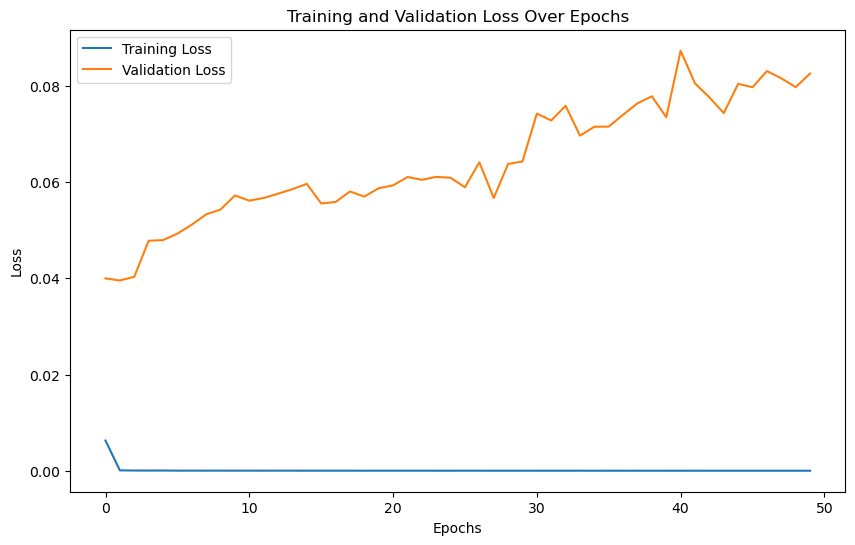

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

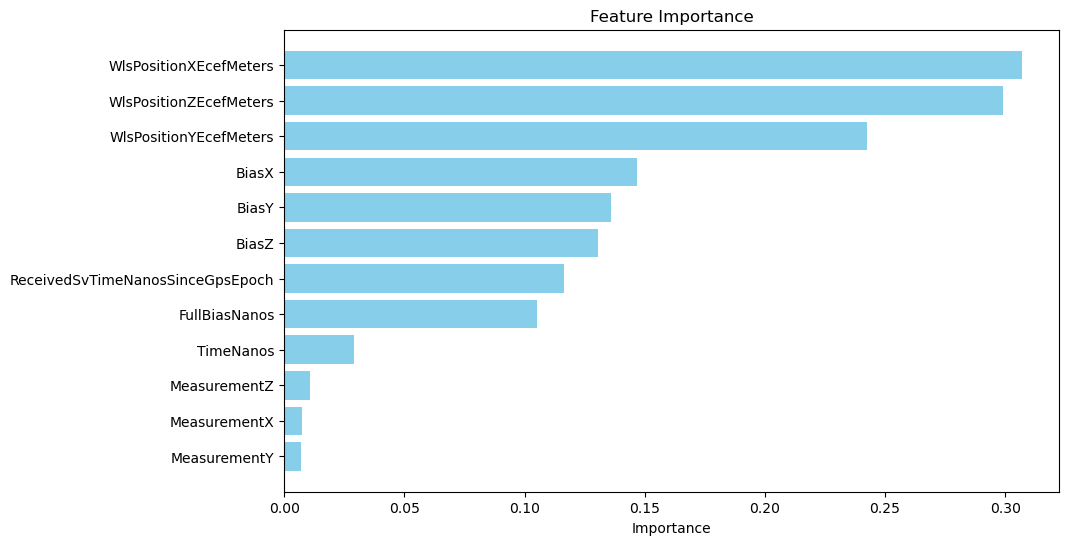

In [71]:
weights_input_hidden = model.layers[0].get_weights()[0]
feature_importance = np.mean(np.abs(weights_input_hidden), axis=1)

input_features = list(x_train.columns)
features_importance_pair = list(zip(input_features, feature_importance))

features_importance_pair.sort(key=lambda x: x[1], reverse=True)
sorted_features, sorted_importance = zip(*features_importance_pair)

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [72]:
test_df2 = pd.read_csv("C:/Users/elmas/Desktop/aiproje/test_merged.csv")

first_two_columns = test_df2.iloc[:, :2]
merged_dff = pd.concat([first_two_columns, results], axis=1)
merged_dff = merged_dff.rename(columns={'tripID': 'tripId', 'utcTimeMillis': 'UnixTimeMillis'})

merged_dff

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715055442,37.524429,-122.348984
1,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715056442,37.524464,-122.348991
2,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715057442,37.524487,-122.348938
3,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715058442,37.524464,-122.348991
4,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715059442,37.524597,-122.348961
...,...,...,...,...
72042,2023-06-15-18-49-us-ca-sjc-ce1/pixel7pro,1686856468000,37.350834,-121.921432
72043,2023-06-15-18-49-us-ca-sjc-ce1/pixel7pro,1686856469000,37.350876,-121.921410
72044,2023-06-15-18-49-us-ca-sjc-ce1/pixel7pro,1686856470000,37.350998,-121.921257
72045,2023-06-15-18-49-us-ca-sjc-ce1/pixel7pro,1686856471000,37.350819,-121.921432


In [73]:
sample_df = pd.read_csv(f"C:/Users/elmas/Desktop/aiproje/kaggle/input/smartphone-decimeter-2023/sdc2023/sample_submission.csv")
sample_df = sample_df.drop(columns=['LatitudeDegrees', 'LongitudeDegrees'])

result_df = pd.merge(sample_df, 
                     merged_dff[['tripId', 'UnixTimeMillis', 'LatitudeDegrees', 'LongitudeDegrees']], 
                     on=['tripId', 'UnixTimeMillis'], 
                     how='left')

# Rename the columns
result_df.columns = ['tripId', 'UnixTimeMillis', 'LatitudeDegrees', 'LongitudeDegrees']
result_df.head()

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees
0,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715055442,37.524429,-122.348984
1,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715056442,37.524464,-122.348991
2,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715057442,37.524487,-122.348938
3,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715058442,37.524464,-122.348991
4,2020-12-11-19-30-us-ca-mtv-e/pixel4xl,1607715059442,37.524597,-122.348961


In [74]:
result_df[['LatitudeDegrees', 'LongitudeDegrees']] = result_df[['LatitudeDegrees', 'LongitudeDegrees']].fillna(method='bfill', limit=2)
result_df.isnull().sum()

tripId              0
UnixTimeMillis      0
LatitudeDegrees     0
LongitudeDegrees    0
dtype: int64

In [75]:
result_df.to_csv('submission.csv', index=False)

In [76]:
def ecef_to_lat_lon(x, y, z):
    a = 6378137.0 
    f = 1 / 298.257223563  
    b = a * (1 - f)  
    e_sq = 1 - (b**2) / (a**2)  

    lon = np.arctan2(y, x)
    p = np.sqrt(x**2 + y**2)
    z = np.abs(z)
    lat_initial = np.arctan2(z, p * (1 - e_sq))

    for i in range(10): 
        N = a / np.sqrt(1 - e_sq * np.sin(lat_initial)**2)
        lat = np.arctan2(z + e_sq * N * np.sin(lat_initial), p)
        if abs(lat - lat_initial) < 1e-10:
            break
        lat_initial = lat
        
    lat = np.degrees(lat)
    lon = np.degrees(lon)
    return lat, lon

actual_df = pd.DataFrame()
actual_df['LatLonX'], actual_df['LatLonY'] = zip(*x_test.apply(lambda row: ecef_to_lat_lon(row['WlsPositionXEcefMeters'], row['WlsPositionYEcefMeters'], row['WlsPositionZEcefMeters']), axis=1))

actual_df.head()

,LatLonX,LatLonY
0,37.523928,-122.349944
1,37.523927,-122.349942
2,37.523919,-122.349956
3,37.523920,-122.349962
4,37.523916,-122.349949


In [77]:
tahmin_edilen = result_df[['LatitudeDegrees', 'LongitudeDegrees']][:1000]
gerçek = actual_df[:1000]

map = folium.Map(location=[0, 0], zoom_start=2)

for index, row in gerçek.iterrows():
    lat, lon = row['LatLonX'], row['LatLonY']
    folium.CircleMarker(location=[lat, lon], radius=1, color='blue', fill=True, fill_color='blue').add_to(map)

for index, row in tahmin_edilen.iterrows():
    lat, lon = row['LatitudeDegrees'], row['LongitudeDegrees']
    folium.CircleMarker(location=[lat, lon], radius=1, color='green', fill=True, fill_color='green').add_to(map)
    
map
